# Model Selection and Hyperparameter Tuning

In [234]:
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, StackingClassifier
from matplotlib import pyplot as plt

In [189]:
training_data_wt = pd.read_csv('Nata_Files/less_features/train_data_lf.csv', index_col=0)
testing_data_wt = pd.read_csv('Nata_Files/less_features/test_data_lf.csv', index_col=0)
prediction_data = pd.read_csv('Nata_Files/less_features/pred_data_lf.csv', index_col=0)
learn = pd.read_csv('Nata_Files/learn.csv', index_col=0)
learn.isna().sum()

ambient_humidity       18
baking_duration         1
cooling_period          1
cream_fat_content      24
egg_temperature        24
egg_yolk_count         24
final_temperature      25
lemon_zest_ph          26
notes_baker          5200
origin                161
oven_temperature       21
pastry_type          1789
preheating_time        19
salt_ratio             13
sugar_content          22
vanilla_extract        18
quality_class           1
dtype: int64

In [140]:
X_train = training_data_wt.drop('target', axis=1)
y_train = training_data_wt['target']
X_test = testing_data_wt.drop('target', axis=1)
y_test = testing_data_wt['target']

In [178]:
logreg = LogisticRegression(solver='sag', multi_class='ovr')

In [241]:
dtc = DecisionTreeClassifier(max_leaf_nodes=100, random_state=42)
knn = KNeighborsClassifier(n_neighbors=3)
bag=BaggingClassifier(max_samples=0.2,estimator=knn, random_state=42, bootstrap=False)
bag.fit(X_train, y_train)
bag.score(X_test, y_test)

0.7361538461538462

In [143]:
bag.score(X_test, y_test)

0.7361538461538462

In [144]:
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=42)

In [182]:
X =
y = pd.concat([y_train, y_test], axis=0).map({'OK':1,'KO':0})


In [146]:
def return_f1score(model, X, y):
    n_scores = cross_val_score(model, X, y, scoring = 'f1', cv = rskf)
    return n_scores

In [183]:
def return_results(models, X = X, y = y):
    results, names = [],[]
    for name, model in models.items():
        scores = return_f1score(model, X, y)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

    plt.figure(figsize=(15,7))
    plt.boxplot(results, labels= names, showmeans = True)
    plt.xticks(fontsize=14)
    plt.show()

>DecisionTree 0.787 (0.017)
>KNeighbors 0.802 (0.012)
>LogisticRegression 0.810 (0.013)


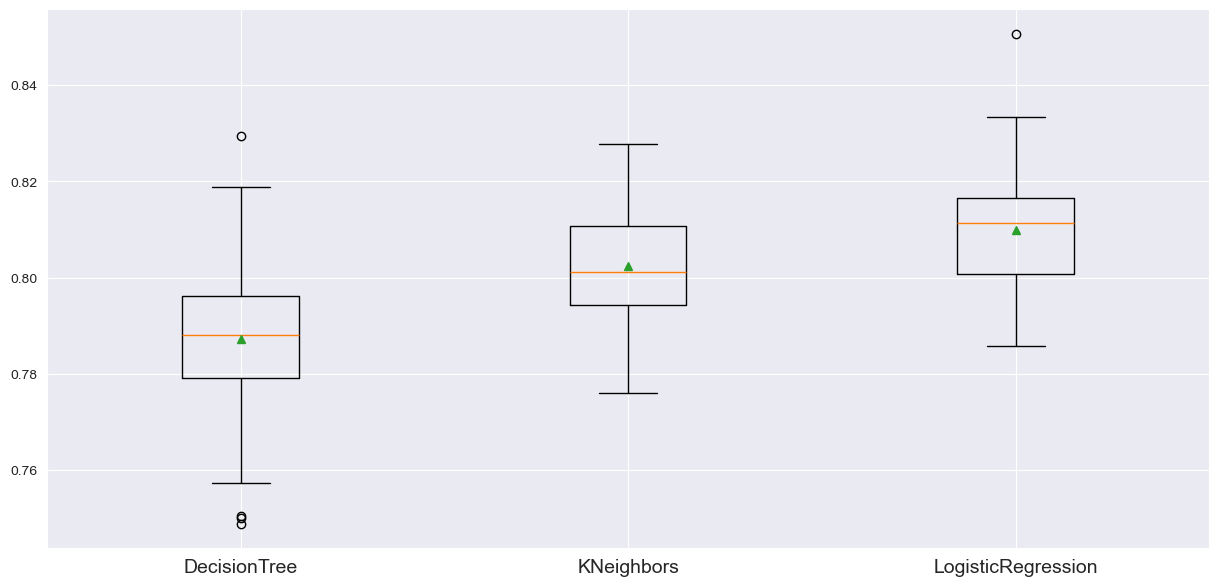

In [184]:
models = {'DecisionTree': dtc,
          'KNeighbors': knn,
          'LogisticRegression': logreg, }
return_results(models)

In [148]:
lreg = logreg.fit(X_train, y_train)
lreg.predict(X_train)
print(lreg.score(X_train, y_train))
print(lreg.score(X_test, y_test))

0.7501285347043701
0.7438461538461538


In [169]:
import numpy as np
from sklearn import datasets, ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    f1_score
)

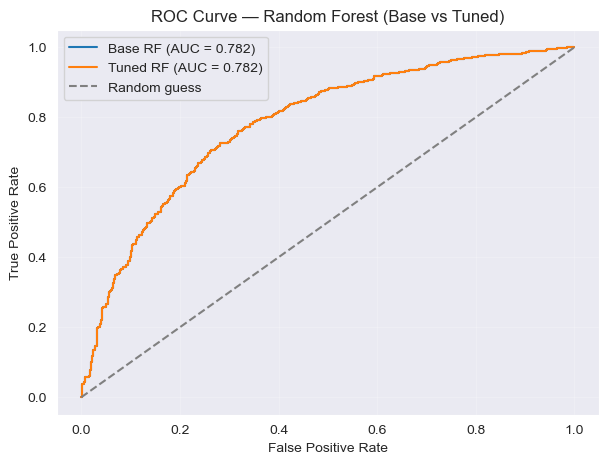

In [166]:
y_train_bin = y_train.map({'OK': 1, 'KO': 0})
y_test_bin  = y_test.map({'OK': 1, 'KO': 0})

y_proba_rf_base = logreg.predict_proba(X_test)[:, 1]
y_proba_rf_tuned = logreg.predict_proba(X_test)[:, 1]

fpr_base, tpr_base, _ = roc_curve(y_test_bin, y_proba_rf_base)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_bin, y_proba_rf_tuned)

auc_base = roc_auc_score(y_test_bin, y_proba_rf_base)
auc_tuned = roc_auc_score(y_test_bin, y_proba_rf_tuned)

plt.figure(figsize=(7, 5))
plt.plot(fpr_base, tpr_base, label=f'Base RF (AUC = {auc_base:.3f})')
plt.plot(fpr_tuned, tpr_tuned, label=f'Tuned RF (AUC = {auc_tuned:.3f})')
plt.plot([0, 1], [0, 1], '--', color='grey', label='Random guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve — Logistic Regression (Base vs Tuned)')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

>True 0.782 (0.016)
>False 0.746 (0.018)


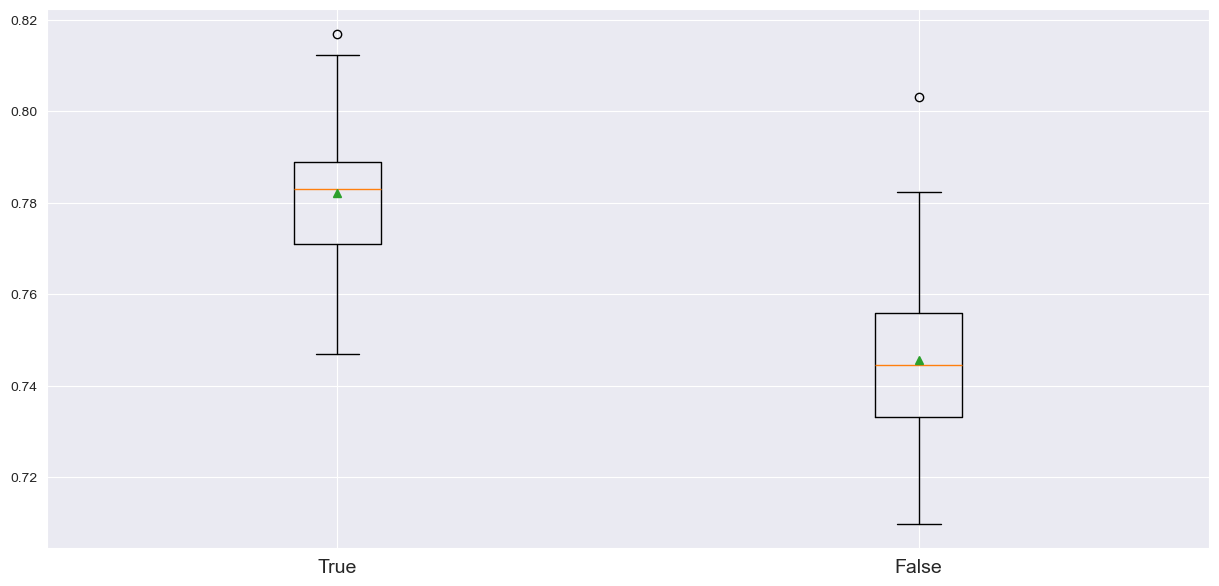

In [171]:
def get_models(values):
    '''Creates a dict of models where the bool value for drawing samples with replacement (True or False) is equal to value.
    The number of models created will be equal to the lenght of vector values'''
    models = dict()
    for value in values:
        models[str(value)] = BaggingClassifier(bootstrap = value, random_state = 5)
    return models

models = get_models([True, False])
return_results(models)

In [228]:
models = [knn, logreg, dtc, bag]
y_df = []
for model in models:
    model.fit(X_train, y_train)
    y_df.append(model.predict(X_train))

In [229]:
y_df = pd.DataFrame(np.array(y_df).T, columns=['knn','logreg','dtc','bag'])
backup = y_df.copy

In [230]:
for col in y_df.columns:
    print(y_df[col])
    y_df[col]=y_df[col].map({'OK':1,'KO':0})
y_df

0       OK
1       OK
2       OK
3       OK
4       OK
        ..
3885    OK
3886    OK
3887    KO
3888    KO
3889    OK
Name: knn, Length: 3890, dtype: object
0       OK
1       OK
2       OK
3       OK
4       OK
        ..
3885    OK
3886    OK
3887    OK
3888    KO
3889    OK
Name: logreg, Length: 3890, dtype: object
0       OK
1       OK
2       OK
3       OK
4       OK
        ..
3885    OK
3886    OK
3887    OK
3888    KO
3889    OK
Name: dtc, Length: 3890, dtype: object
0       OK
1       OK
2       OK
3       OK
4       OK
        ..
3885    OK
3886    OK
3887    OK
3888    KO
3889    OK
Name: bag, Length: 3890, dtype: object


,knn,logreg,dtc,bag
0,1,1,1,1
1,1,1,1,1
2,1,1,1,1
3,1,1,1,1
4,1,1,1,1
...,...,...,...,...
3885,1,1,1,1
3886,1,1,1,1
3887,0,1,1,1
3888,0,0,0,0


In [245]:
logreg.fit(y_df, y_train)
logreg.score(y_df, y_train)

0.860668380462725

In [242]:
estimators = [('knn', knn), ('logreg', logreg), ('dtc', dtc), ('bag', bag)]

In [243]:
stack = StackingClassifier(estimators=estimators,final_estimator=LogisticRegression()).fit(X_train,y_train)

In [244]:
stack.score(X_train, y_train), stack.score(X_test, y_test)

(0.8264781491002571, 0.7638461538461538)